## Imports and Setup

Run these in command prompt to install the libraries used
* pip install imagehash
* pip install torch torchvision
* pip install matplotlib
* pip install pillow
* pip install tqdm
* pip install opencv-python
* pip install torchsummary
* pip install scikit-image
* pip install opencv-python

Importing the Libraries that we are using

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr

setting some constants

In [2]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

## Preprocessing and creating dataset

Preprocessing the images to create the dataset of color and grayscale images pairs.
* Normalising the Image pixel value between 0 - 1
* Resizing Images
* splitting images to train and test

In [3]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './image_dataset'
        self.images = os.listdir(f'{self.dataroot}')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/{img_path}') / 255
        gray_img = transforms.Grayscale()(color_img)

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img

## Data Transformation

Apply transformations to your images (resizing) to prepare them for the model. Also splitting the image into train, validation and test datasets. 70% of the data will be train and 15% will be validation and remaining will be test.

In [4]:
# Resize the images
transform = transforms.Compose([
    transforms.Resize((160, 160), antialias=False),
])

# Load the dataset with transformation
dataset = LandscapeDataset(transform=transform)

# Define the sizes for train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Use random_split to split the dataset into train, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train, validation, and test data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)  # No need to shuffle validation data
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)  # No need to shuffle test data

Just visualizing images randomly to see how we got the data

In [249]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(4):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

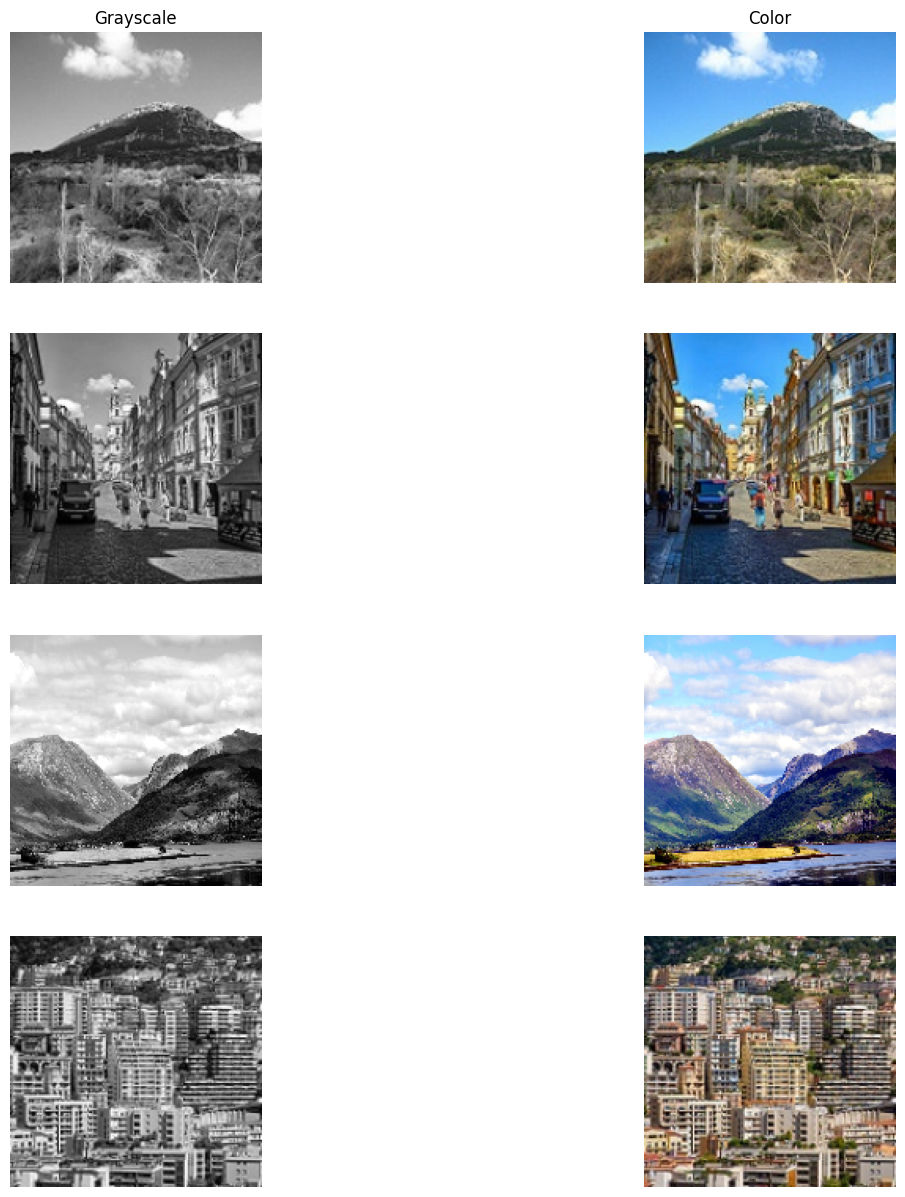

In [250]:
color, gray = next(iter(trainloader))
show_images(color, gray)

Initializing Training Constants

In [5]:
# Training Variables

EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model Architecture

Creating an Autoencoder Architecture. Has an Encoder and a Decoder in it.
* Encoder:
- Downsampling Images:
- The Encoder has special filters that look at the details of a picture. These filters start simple and become more complex. Think of it like zooming out from a detailed view to a bigger picture.
Each filter creates a new version of the picture with fewer details. So, it's like making the picture a bit blurry, but we keep the important parts.

* Decoder:
- Upsampling Images:
- Now, the Decoder takes these simplified pictures and tries to recreate the original detailed picture.
It uses special tools to add details back, making the picture sharper. It's like zooming back in but trying to recover the important details.

* Encoder has a down1 to down4 are convolutional layers with increasing numbers of output channels. They perform downsampling of the input image.
* Decoder has a up1 to up4 are transposed convolutional layers (also known as deconvolution or upsampling layers). They perform upsampling of the encoded representation.
* Also initialized the activation functions using to train the neural network. ReLU (Rectified Linear Unit) is used as the activation function after each convolutional and transposed convolutional layer, except for the last layer of the decoder, where Sigmoid is used.
* The forward method defines the forward pass of the network. It applies the convolutional and transposed convolutional layers, interleaved with activation functions, to encode and then decode the input.
* The final output u4 is the colorized image, and sigmoid is used to ensure that the pixel values are between 0 and 1.

![](autoencode_architecture.png)

In [6]:
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        
        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        
        # Decoder
        x = self.decoder(x)
        
        return x

Initializing the model and checking the number of parameters to trained.

In [7]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,139,011'

### Model Summary

In [8]:
summary(model, input_size=(1, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             320
              ReLU-2         [-1, 32, 160, 160]               0
       BatchNorm2d-3         [-1, 32, 160, 160]              64
            Conv2d-4           [-1, 64, 80, 80]          18,496
              ReLU-5           [-1, 64, 80, 80]               0
       BatchNorm2d-6           [-1, 64, 80, 80]             128
            Conv2d-7          [-1, 128, 40, 40]          73,856
              ReLU-8          [-1, 128, 40, 40]               0
       BatchNorm2d-9          [-1, 128, 40, 40]             256
           Conv2d-10          [-1, 256, 20, 20]         295,168
             ReLU-11          [-1, 256, 20, 20]               0
      BatchNorm2d-12          [-1, 256, 20, 20]             512
           Conv2d-13          [-1, 512, 10, 10]       1,180,160
             ReLU-14          [-1, 512,

## Initialize Model, Loss, and Optimizer

Inializing the loss function and the optimizer using

* Loss Function: Think of the loss function as a score that tells the computer how much it needs to improve. A lower score means the computer is getting better at coloring the pictures.
* optimizer: If the loss function is the score, the optimizer is the coach that guides the computer to take small steps in the right direction. It's like a coach helping you improve your basketball skills by adjusting your technique.

In [9]:
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training Loop

Now the training starts

* Practice Sessions (Epochs):
We're giving the model many practice sessions. In each session, it looks at pictures and tries to add colors.

* Breaking Practice into Steps (Batches):
Each practice session is divided into smaller steps. In each step, the model looks at a bunch of pictures.

* Looking at Pictures:
The model looks at both a grayscale picture (no colors) and a real colored picture.

* Trying to Colorize:
It tries to add colors to the grayscale picture using its current skills.

* Checking its Work (Loss):
Checks how different the model's colored picture is from the real one. This difference is called "loss."

* Getting Feedback (Optimization):
The optimizer tells the model how to adjust its coloring strategy to get closer to the real colors. This is the model's way of getting better.

* Many Rounds of Practice (Iterations):
The model repeats these steps many times, practicing and adjusting its approach to coloring.

* Getting Better Each Time:
After each round of practice, we check how much the model improved on average.

* Finally:
After all the practice sessions, we say, "Training Finished!" The model has learned how to color pictures better.

### Code for calculating the SSIM(Structural Similarity Index) value.

In [10]:
def calculate_ssim(img1, img2, k1=0.01, k2=0.03, L=1):
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2

    mu1 = np.mean(img1)
    mu2 = np.mean(img2)

    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    sigma12 = np.cov(img1.flatten(), img2.flatten())[0, 1]

    numerator = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    denominator = (mu1 ** 2 + mu2 ** 2 + c1) * (sigma1_sq + sigma2_sq + c2)

    ssim = numerator / denominator

    return ssim

In [271]:
train_loss_values = []
train_psnr_values = []
train_ssim_values = []
val_loss_values = []
val_psnr_values = []
val_ssim_values = []

# Define the training loop
for epoch in range(EPOCHS):
    # Training
    model.train()  # Set the model to training mode

    running_loss = 0.0
    total_mse = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate Mean Squared Error for PSNR
        mse = torch.nn.functional.mse_loss(color_img, predictions)
        total_mse += mse.item()

    # Calculate and print PSNR
    train_psnr = psnr(color_img.cpu().detach().numpy(), predictions.cpu().detach().numpy(), data_range=1.0)
    # train_ssim = calculate_ssim(color_img, predictions)
    train_ssim = calculate_ssim(color_img.cpu().detach().numpy(), predictions.cpu().detach().numpy())

    # Store values for plotting
    train_loss_values.append(running_loss / len(trainloader))
    train_psnr_values.append(train_psnr)
    train_ssim_values.append(train_ssim)
    
    print(f'Epoch: {epoch + 1}, Loss: {running_loss / len(trainloader):.6f}, PSNR: {train_psnr:.6f}, SSIM: {train_ssim:.6f}')

    # Validation    
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_total_mse = 0.0

    with torch.no_grad():
        for idx, (val_color_img, val_gray_img) in tqdm(enumerate(valloader), total=len(valloader)):
            val_color_img = val_color_img.to(DEVICE)
            val_gray_img = val_gray_img.to(DEVICE)

            val_predictions = model(val_gray_img)

            # Calculate validation loss
            val_loss = criterion(val_color_img, val_predictions)
            val_running_loss += val_loss.item()

            # Calculate Mean Squared Error for PSNR
            val_mse = torch.nn.functional.mse_loss(val_color_img, val_predictions)
            val_total_mse += val_mse.item()

    # Calculate and print validation PSNR
    val_psnr = psnr(val_color_img.cpu().numpy(), val_predictions.cpu().numpy(), data_range=1.0)
    val_ssim = calculate_ssim(val_color_img.cpu().numpy(), val_predictions.cpu().numpy())
    
    # Store values for plotting
    val_loss_values.append(val_running_loss / len(valloader))
    val_psnr_values.append(val_psnr)
    val_ssim_values.append(val_ssim)

    print(f'Epoch: {epoch + 1}, Validation Loss: {val_running_loss / len(valloader):.6f}, Validation PSNR: {val_psnr:.6f}, Validation SSIM: {val_ssim:.6f}')

print('Training Finished!')

100%|██████████| 405/405 [05:16<00:00,  1.01it/s]
Epoch: 1, Loss: 0.017448, PSNR: 18.434221, SSIM: 0.808438
100%|██████████| 87/87 [00:29<00:00,  3.02it/s]
Epoch: 1, Validation Loss: 0.012830, Validation PSNR: 18.421192, Validation SSIM: 0.819302
100%|██████████| 405/405 [05:20<00:00,  1.14it/s]
Epoch: 2, Loss: 0.011786, PSNR: 20.331186, SSIM: 0.812342
100%|██████████| 87/87 [00:27<00:00,  3.67it/s]
Epoch: 2, Validation Loss: 0.010726, Validation PSNR: 19.297804, Validation SSIM: 0.821215
100%|██████████| 405/405 [05:44<00:00,  1.79it/s]
Epoch: 3, Loss: 0.010308, PSNR: 19.966449, SSIM: 0.816784
100%|██████████| 87/87 [00:32<00:00,  4.01it/s]
Epoch: 3, Validation Loss: 0.009492, Validation PSNR: 19.918361, Validation SSIM: 0.823452
100%|██████████| 405/405 [05:25<00:00,  1.90it/s]
Epoch: 4, Loss: 0.009664, PSNR: 20.331160, SSIM: 0.820523
100%|██████████| 87/87 [00:34<00:00,  2.11it/s]
Epoch: 4, Validation Loss: 0.009357, Validation PSNR: 20.114031, Validation SSIM: 0.825701
100%|███████

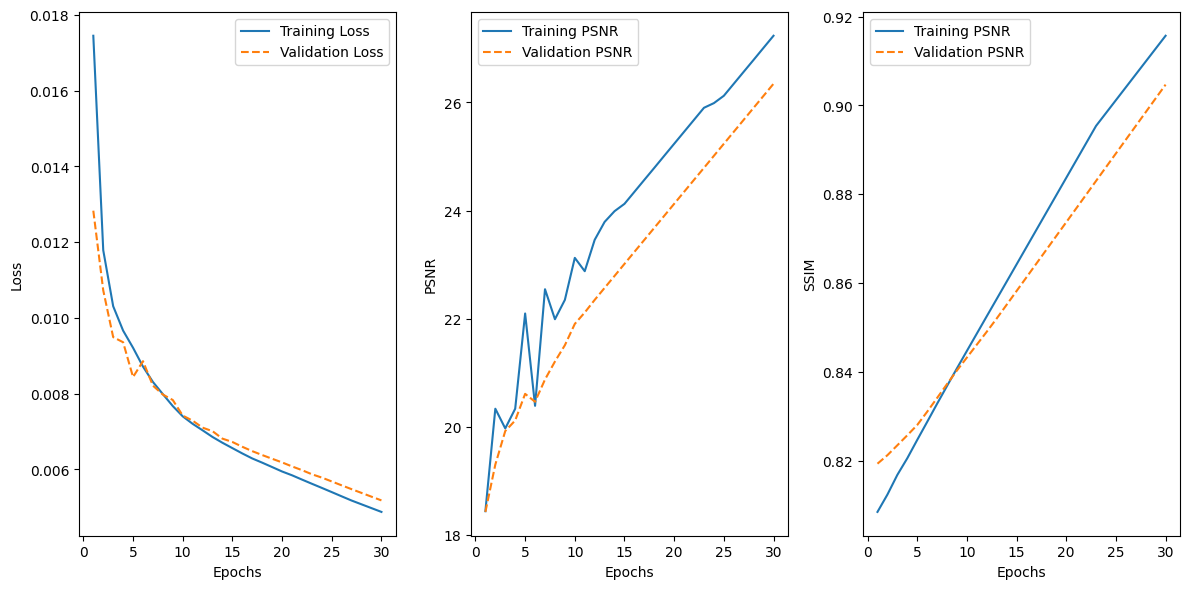

In [274]:
# Plot training and validation results in the same plot
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))

# Plot Training Loss and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_list, train_loss_values, label='Training Loss')
plt.plot(epochs_list, val_loss_values, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_list, train_psnr_values, label='Training PSNR')
plt.plot(epochs_list, val_psnr_values, label='Validation PSNR', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

# Plot Training Accuracy and Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs_list, train_ssim_values, label='Training PSNR')
plt.plot(epochs_list, val_ssim_values, label='Validation PSNR', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

plt.tight_layout()
plt.show()


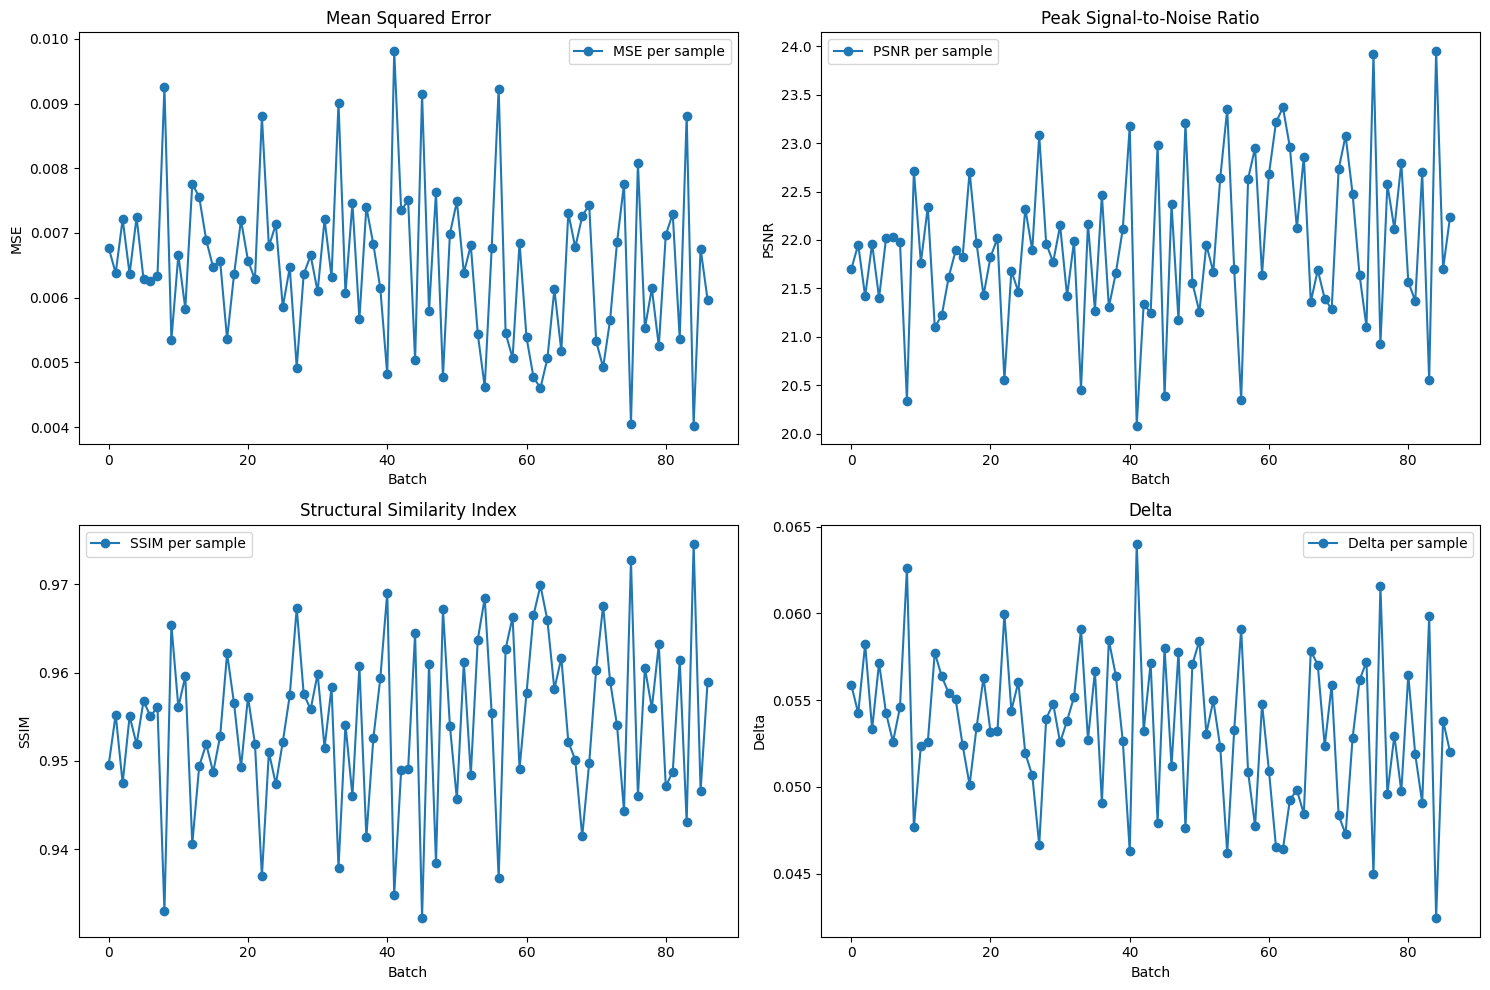

In [13]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to accumulate metrics
mse_values = []
psnr_values = []
ssim_values = []
delta_values = []

# Define Delta function
def delta(image1, image2):
    return torch.mean(torch.abs(image1 - image2))

# Evaluate on the test set
with torch.no_grad():
    for idx, (color_img, gray_img) in enumerate(testloader):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        # Calculate Mean Squared Error
        mse = torch.nn.functional.mse_loss(color_img, predictions)
        mse_values.append(mse.item())

        # Calculate Peak Signal-to-Noise Ratio
        psnr_value = psnr(color_img.cpu().numpy(), predictions.cpu().numpy(), data_range=1.0)
        psnr_values.append(psnr_value)

        # Calculate Structural Similarity Index
        ssim_value = calculate_ssim(color_img.cpu().numpy(), predictions.cpu().numpy())
        ssim_values.append(ssim_value)

        # Calculate Delta
        delta_value = delta(color_img, predictions)
        delta_values.append(delta_value.item())

# Plotting
plt.figure(figsize=(15, 10))

# Plot MSE
plt.subplot(2, 2, 1)
plt.plot(range(len(mse_values)), mse_values, label='MSE per sample', marker='o')
plt.xlabel('Batch')
plt.ylabel('MSE')
plt.title('Mean Squared Error')
plt.legend()

# Plot PSNR
plt.subplot(2, 2, 2)
plt.plot(range(len(psnr_values)), psnr_values, label='PSNR per sample', marker='o')
plt.xlabel('Batch')
plt.ylabel('PSNR')
plt.title('Peak Signal-to-Noise Ratio')
plt.legend()

# Plot SSIM
plt.subplot(2, 2, 3)
plt.plot(range(len(ssim_values)), ssim_values, label='SSIM per sample', marker='o')
plt.xlabel('Batch')
plt.ylabel('SSIM')
plt.title('Structural Similarity Index')
plt.legend()

# Plot Delta
plt.subplot(2, 2, 4)
plt.plot(range(len(delta_values)), delta_values, label='Delta per sample', marker='o')
plt.xlabel('Batch')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend()

plt.tight_layout()
plt.show()

## Visualization

Finally we are predicting the model with the images. Here, visualized the original, gray scale and the predicted output images using matplotlib

In [280]:
# Visualize some predictions
def show_predictions(gray, color, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()


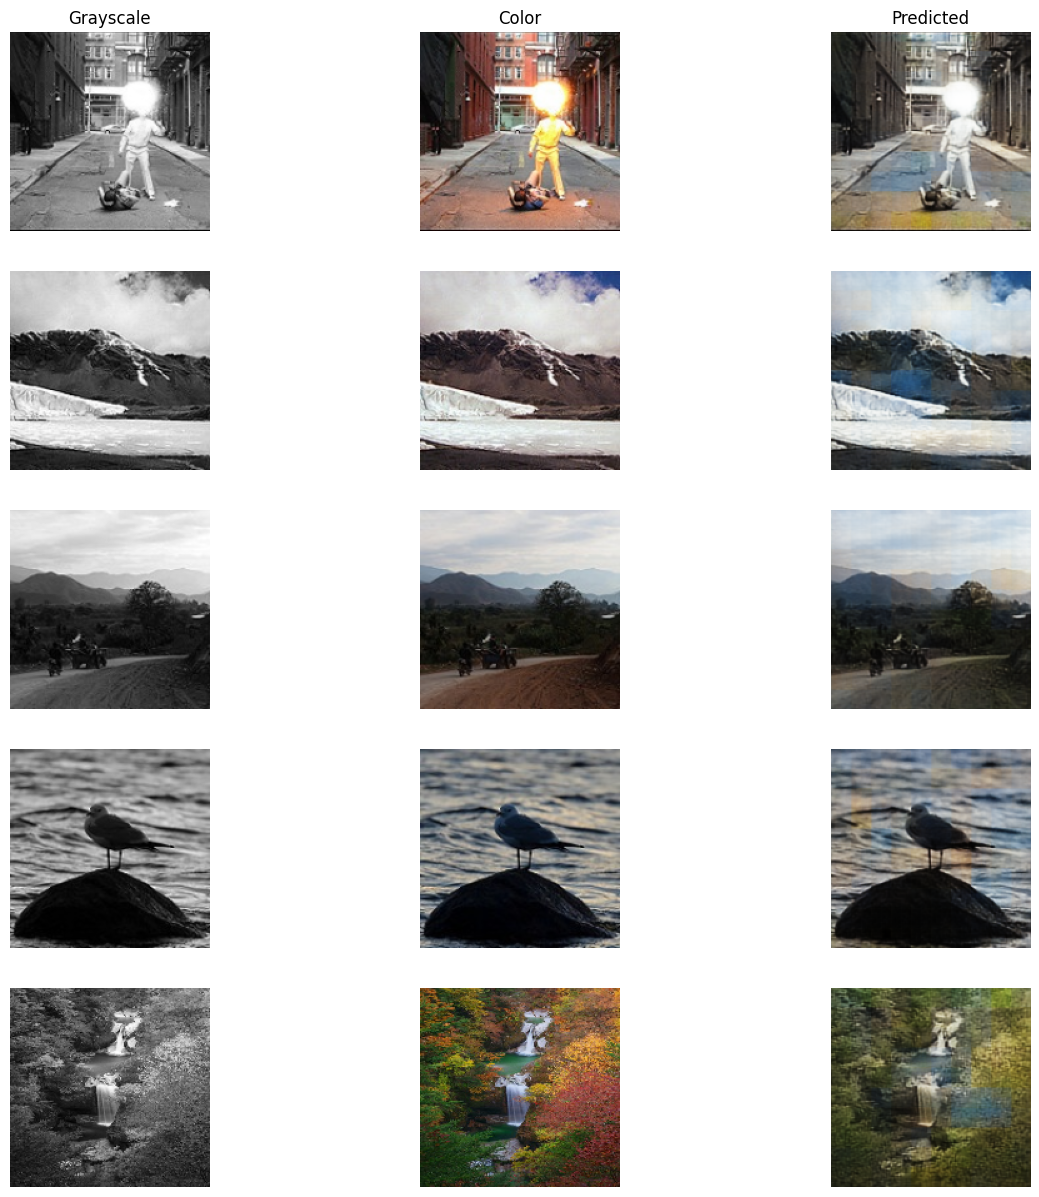

In [282]:
show_predictions(gray_img.detach().cpu(), color_img.detach().cpu(), predictions.detach().cpu())

## Predictions

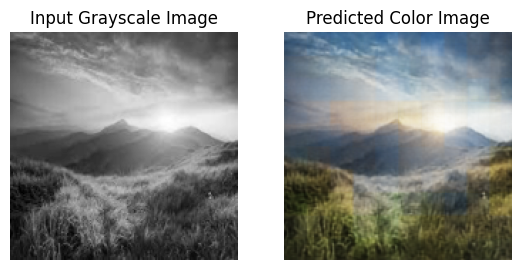

In [285]:
# Assuming 'model' is your trained autoencoder model

def predict_image(model, input_image_path):
    # Read and preprocess the new image
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
    ])

    input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
    input_image = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Move input image to the same device as the model
    device = next(model.parameters()).device
    input_image = input_image.to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_image = model(input_image)

    # Move the predicted image back to CPU for visualization
    predicted_image = predicted_image.cpu()

    return input_image.squeeze(0), predicted_image.squeeze(0)

# Example usage:
input_image_path = 'predict_img/33.jpg'
input_image, predicted_image = predict_image(model, input_image_path)

# Visualize the input grayscale image, original color image, and predicted color image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title('Input Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image.permute(1, 2, 0).numpy())
plt.title('Predicted Color Image')
plt.axis('off')

plt.show()

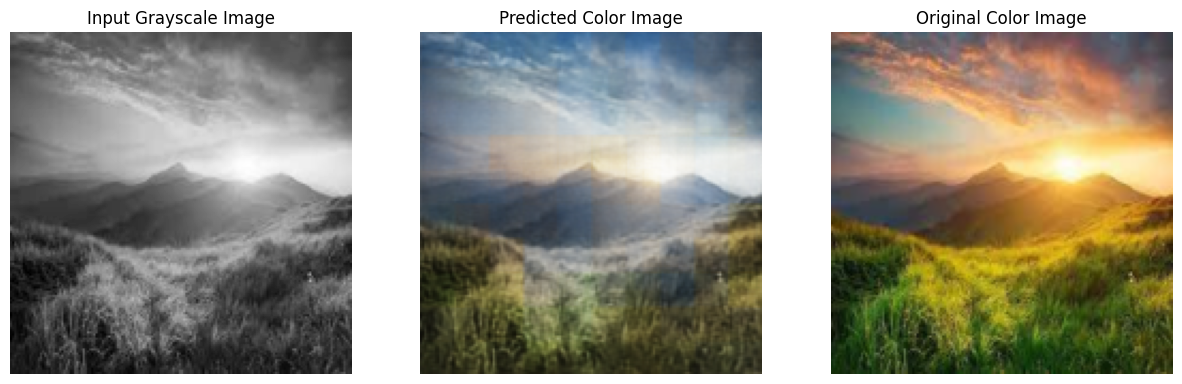

In [286]:
def predict_and_visualize(model, original_color_path):
    # Read and preprocess the new grayscale image
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
    ])

    input_gray = Image.open(original_color_path).convert('L')  # Convert to grayscale
    input_gray = transform(input_gray).unsqueeze(0)  # Add batch dimension
    input_gray = input_gray.to(next(model.parameters()).device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        predicted_color = model(input_gray)

    # Move the predicted color image back to CPU for visualization
    predicted_color = predicted_color.cpu()

    # Read and preprocess the original color image
    original_color = Image.open(original_color_path)
    original_color = transform(original_color).unsqueeze(0)  # Add batch dimension

    # Visualize the images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(input_gray.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Input Grayscale Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Predicted Color Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_color.squeeze().permute(1, 2, 0).numpy())
    plt.title('Original Color Image')
    plt.axis('off')

    plt.show()

# Example usage:
original_color_path = 'predict_img/33.jpg'
predict_and_visualize(model, original_color_path)


## Saving the model

Saving the model for future uses. We can integrate it into various places.

In [ ]:
# Save the model
# torch.save(model.state_dict(), 'your_model.pth')
